In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import HTML

In [2]:

import numpy as np
import os
import data_utils
import pickle
import attacks
import random
from keras.models import load_model

import greedy_utils

Using TensorFlow backend.


In [3]:
TOKENIZER_PATH = 'tokenizer.pickle'
TEXT_DATA_DIR = '20_newsgroup/'
MODEL_PATH = '20news_model.h5'

In [4]:
tokenizer, inverse_tokenizer = data_utils.load_tokenizer(TOKENIZER_PATH)
model = load_model(MODEL_PATH)
labels =  list(sorted(os.listdir(TEXT_DATA_DIR)))

In [5]:
sample_file, true_label = data_utils.pick_random_file(TEXT_DATA_DIR)
file_text = data_utils.load_textfile(sample_file)
file_features = data_utils.process_text(tokenizer, file_text)

In [6]:
pred_scores = model.predict(file_features)
orig_prediction = np.argmax(pred_scores[0])
print('TrueLabel = %s' %true_label)
print('Predicted "%s" with %f .' %(labels[orig_prediction], pred_scores[0][orig_prediction]))

TrueLabel = talk.politics.mideast
Predicted "talk.politics.mideast" with 0.283052 .


## Randomised Attack (Non-targeted)

 Random attack will pick and replace words randomly.

In [9]:
COMPUTE_PROBS = False
if COMPUTE_PROBS:
    num_words = len(inverse_tokenizer)
    topics_words, topics_words_probs = greedy_utils.compute_topic_words(TEXT_DATA_DIR, tokenizer, 
                                                                  labels, num_words)
    with open('topic_words.pickle', 'wb') as handle:
        pickle.dump(topics_words, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('topc_words_probs.pickle', 'wb') as handle:
        pickle.dump(topics_words_probs, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('topic_words.pickle', 'rb') as handle:
        topics_words = pickle.load(handle)
    with open('topc_words_probs.pickle', 'rb') as handle:
        topics_words_probs = pickle.load( handle)

In [68]:
greedy_attack = attacks.GreedyAttack(model, topics_words, topics_words_probs, temp=0.15)

In [69]:
other_labels = [x for x in range(len(labels)) if x != orig_prediction]
random_target = np.random.choice(other_labels)
print('Random target = %s' %labels[random_target])
x_orig = file_features.copy()
x_adv, o_hist, t_hist = greedy_attack.attack(x_orig, random_target)

Random target = rec.motorcycles


Attack succeeded after 108 iterations.
Original class: talk.politics.mideast, Attack class: rec.motorcycles
Number of changed words = 87 (28.16 %)


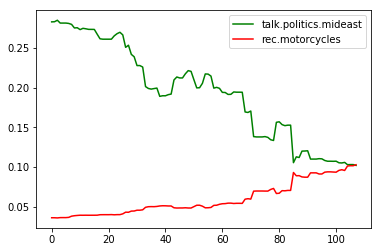

In [70]:
if x_adv is None:
    print('Attack failed. !')
else:
    adv_prediction = np.argmax(model.predict(x_adv))
    print('Attack succeeded after %d iterations.' %(len(t_hist)))
    print('Original class: %s, Attack class: %s' %(labels[orig_prediction], labels[adv_prediction]))
    print("Number of changed words = %d (%0.2f %%)"
          %(np.count_nonzero(x_adv != x_orig),
            100*(np.count_nonzero(x_adv != x_orig))/np.count_nonzero(x_orig)))
    plt.plot(o_hist, 'g', label=labels[orig_prediction])
    plt.plot(t_hist, 'r', label=labels[adv_prediction])
    plt.legend()

## Reconstruct Text Document

In [71]:
orig_text = data_utils.reconstruct_text(inverse_tokenizer, file_features[0])
adv_text = data_utils.reconstruct_text(inverse_tokenizer, x_adv[0])

## Visualize Attack

In [72]:
orig_html, adv_html = data_utils.render_attack(orig_text, adv_text)

In [73]:
HTML("<b> Original Text </b>")
HTML(orig_html)

In [74]:
HTML("<b> Adversarial Text </b>")
HTML(adv_html)